In [5]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

from ModelTesters.ModelTester import ModelTester
from utils.DataPrepUtils import xy_backtest
from utils.progress import ProgressBar
progress = ProgressBar()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

## KRR Model

## Kernel ridge regression

In [38]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor

In [39]:
model = MultiOutputRegressor(KernelRidge())

In [40]:
from AutoValidator.ErrorMetrics import calculate_all_errors, __error_metrics__

def speed_up_calc(tester, data, horizon, back_horizon):
    # Loading bar
    tester.progressBar.set_length(len(data.columns) * 10)

    # walk speed up
    for i, column in enumerate(data.keys()):
        # Split into train and test data
        split = int(0.20 * len(data))
        train, test = data[column][:split].values, data[column][split:].values
        
        tester.predictions[column] = np.zeros((int((len(data) - len(data) * 0.2)), horizon))
        
        # Round to be a multiple of the horizon
        test = test[:len(test) - len(test) % horizon]
        
        col = data[column].values.flatten()
        indexer = np.arange(back_horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
        X = col[indexer]
    
        indexer = back_horizon + np.arange(horizon)[None, :] + horizon * np.arange((len(col) - 2 * back_horizon) // horizon)[:, None]
        y = col[indexer]
        
        cum_sum = 0
        set_errors = pd.DataFrame(columns=__error_metrics__)
        for (X_train, X_test, y_train, y_test) in xy_backtest(X, y, 0.2, int(0.8 * len(X)) // 10): 
            # Only use most max_samples training samples
            max_samples = 3000
            max_samples_index = -max_samples
            X_train, y_train = X_train[max_samples_index:], y_train[max_samples_index:]        
            print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

            tester.model.fit(X_train, y_train)
            pred = tester.model.predict(X_test)

            print(cum_sum, cum_sum + len(pred), len(pred))
            tester.predictions[column][cum_sum:cum_sum + len(pred)] = pred
            cum_sum += len(pred)

            print(y_test.shape, y_test.shape, y_train.shape)
            errors = {}
        
            for key, value in calculate_all_errors(X_train, y_test[:, 0], pred, horizon).items():
                errors[key] = [value]
            
            t = pd.DataFrame.from_dict(errors)
            t.set_index(keys=[[column]], inplace=True)
            set_errors = set_errors.append(t)

            tester.progressBar.progress()
            
        tester.errors = tester.errors.append(set_errors.loc[column].mean(axis=0), ignore_index=True)
            
        tester.predictions[column] = tester.predictions[column][:cum_sum]
            

## 1 minute horizon

In [7]:
horizon = 1

one_min_tester = ModelTester(data, model, horizon, 0.20)

In [8]:
speed_up_calc(one_min_tester, data, horizon, 30)

Progress: [####################] 100.0%


In [79]:
# Optional load results
# one_min_tester.errors = pd.read_csv('results/one_minute_krr_results.csv', index_col='Unnamed: 0')

In [82]:
one_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE1,MEAN_ASE
window_1_0,34.133627,99.140301,40.208585,14.293319,0.121536,-0.613784,0.119043
window_1_1,34.396846,97.233521,45.707003,12.688743,0.116541,-12.183116,0.116134
window_1_2,45.659042,113.716593,139.749846,16.559170,0.141034,-4.143276,0.138743
window_1_3,50.196247,128.536369,71.615779,16.284109,0.132974,-1.035563,0.130809
window_1_4,52.517607,128.196670,108.317668,19.286231,0.175804,-21.959176,0.179857


Text(0.5,1,'MASE vs H for KRR at 1 minute horizon')

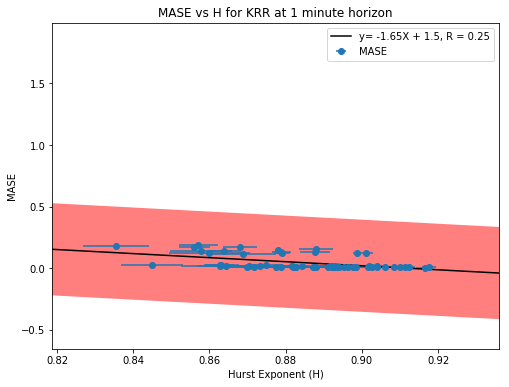

In [18]:
one_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for KRR at 1 minute horizon')

In [78]:
one_min_tester.errors.to_csv('results/one_minute_krr_results.csv')

In [ ]:
one_min_tester.visualise_result([0])

## 5 minute horizon

In [36]:
horizon = 5

five_min_tester = ModelTester(data, model, horizon, 0.20)

In [41]:
speed_up_calc(five_min_tester, data, horizon, 40)

Progress: [####################] 100.0%


In [48]:
# Optional load results
five_min_tester.errors = pd.read_csv('results/five_minute_krr_results.csv', index_col='Unnamed: 0')

In [49]:
five_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE,MASE1
0,92.314558,215.562605,83.290818,35.264626,0.325418,NaN,NaN,0.318344,-81.087469
1,103.044720,251.586085,96.557046,33.530787,0.374670,NaN,NaN,0.345501,13.307724
2,132.494151,292.257533,506.983153,41.388447,0.417104,NaN,NaN,0.406138,89.593635
3,141.493056,315.276282,95.063989,39.059426,0.365006,NaN,NaN,0.369151,-2.727888
4,150.517451,331.203890,105.456975,48.551578,0.511368,NaN,NaN,0.518544,0.018011


(-1, 1.5)

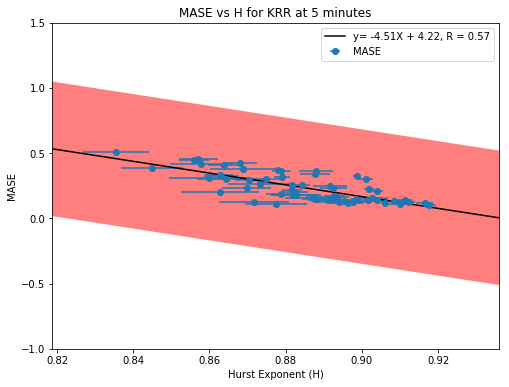

In [51]:
five_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for KRR at 5 minutes')
plt.ylim([-1, 1.5])

In [47]:
five_min_tester.errors.to_csv('results/five_minute_krr_results.csv')

<IPython.core.display.Javascript object>


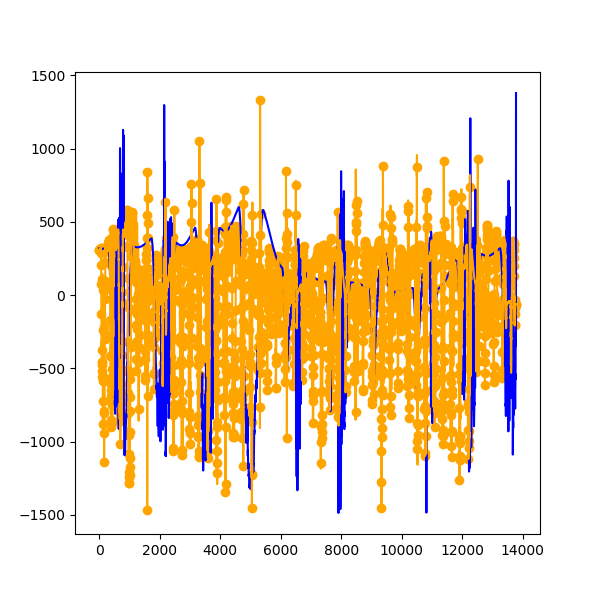

In [127]:
five_min_tester.visualise_result([0])

## 60 minute horizon

In [55]:
horizon = 60

sixty_min_tester = ModelTester(data, model, horizon, 0.20)

In [56]:
speed_up_calc(sixty_min_tester, data, horizon, 60)

Progress: [####################] 100.0%


In [89]:
# Load results if required
sixty_min_tester.errors = pd.read_csv('results/sixty_minute_krr_results.csv', index_col='Unnamed: 0')

In [91]:
sixty_min_tester.errors.head()

,MAE,RMSE,MAPE,sMAPE,MASE,MASE2,MASE3,MEAN_ASE,MASE1
window_1_0,386.892525,546.322117,368.883476,130.417029,1.404861,NaN,NaN,1.313736,-97678.455316
window_1_1,419.833499,653.807447,355.356604,136.628457,1.668026,NaN,NaN,1.359121,-457.728756
window_1_2,408.782006,550.223002,592.838882,145.131181,1.307865,NaN,NaN,1.284827,-33.371527
window_1_3,487.971909,644.433487,235.746304,133.906417,1.253303,NaN,NaN,1.250185,-163.413051
window_1_4,381.438341,527.244455,682.328847,149.070480,1.291746,NaN,NaN,1.319007,517.760060


(-0.8, 3)

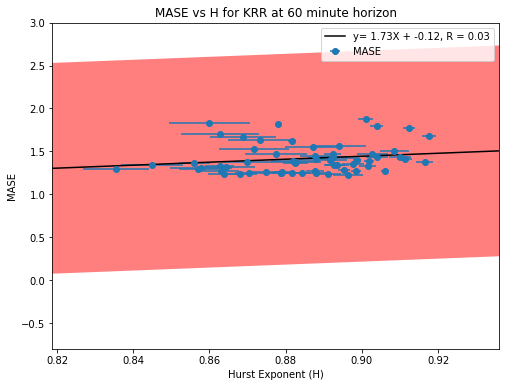

In [92]:
sixty_min_tester.compare_hurst(hurst_estimates, err_to_use='MASE')
plt.title('MASE vs H for KRR at 60 minute horizon')
plt.ylim([-0.8, 3])

In [88]:
sixty_min_tester.errors.to_csv('results/sixty_minute_krr_results.csv')